# Cumulative Time Series Analysis 

Importance of time series analysis in SWE data
Methods and models for time series analysis




## Overview

This chapter focus is on process and analyze Snow Water Equivalent (SWE) and meteorological data to prepare it for time series analysis. Addresses several key aspects of data preparation, including data cleaning, handling missing data, data interpolation, and transformation of data into a suitable format for analysis. The end goal is to facilitate the examination of SWE dynamics and related meteorological variables over time, enabling more accurate and insightful environmental and climatic analyses.

## Program Execution Flow


### Importing the libraries and Input files

In [1]:
#Importing the required libraries
import pandas as pd
import os
import shutil
import numpy as np
import dask.dataframe as dd

homedir = os.path.expanduser('~')
work_dir = f"../data"

# Set Pandas options to display all columns
pd.set_option('display.max_columns', None)


# Define file paths for various CSV files
current_ready_csv_path = f'{work_dir}/final_merged_data_3yrs_all_active_stations_v1.csv_sorted.csv'
cleaned_csv_path = f"{current_ready_csv_path}_cleaned_nodata.csv"
target_time_series_csv_path = f'{cleaned_csv_path}_time_series_v1.csv'
backup_time_series_csv_path = f'{cleaned_csv_path}_time_series_v1_bak.csv'
target_time_series_cumulative_csv_path = f'{cleaned_csv_path}_time_series_cumulative_v1.csv'

Initially, it imports necessary libraries such as Pandas, os, shutil, numpy, and Dask.dataframe.

**Pandas** is a powerful data manipulation library in Python used for data analysis and manipulation. It provides data structures like DataFrame and Series, which are highly efficient for handling structured data like CSV files

The **shutil** module offers a high-level interface for file operations, including copying, moving, and removing files and directories. It's used for file manipulation tasks that are more complex than what the os module provides.

**NumPy** is a fundamental library for scientific computing in Python. It provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays efficiently.

**Dask** is a parallel computing library in Python that enables scalable and distributed computing. It extends the capabilities of libraries like Pandas, NumPy, and Scikit-learn to handle datasets that are larger than memory or can benefit from parallel processing. Dask dataframes, similar to Pandas dataframes, allow for efficient manipulation of larger-than-memory datasets by parallelizing operations across multiple cores or machines.

By default, Pandas truncates the display of columns if they exceed a certain number, making it difficult to see the entire dataset when printed. So Pandas options are set to display all columns when printing data frames.

We are importing the file which we have created in the previous chapter by integrating all the data from different sources.

The defined file paths indicate paths for various stages of data processing, such as cleaned data, time-series data, and backup files. Overall, the code sets up file paths and options necessary for handling CSV data effectively.

### Cleaning and Preparation

Cleaning the dataset to remove rows with missing SWE values, ensuring that the subsequent analysis is based on complete and accurate data. This step is critical for maintaining the integrity of the analysis, as missing values can significantly skew results and interpretations.

#### clean_non_swe_rows

- **Purpose:** Removes rows from the dataset where 'swe_value' is missing. This initial cleaning step is crucial for ensuring the dataset's integrity for further processing and analysis.
- **Implementation:** Utilizes Dask for efficient processing of potentially large datasets, ensuring scalability and performance.

In [22]:
def clean_non_swe_rows(current_ready_csv_path, cleaned_csv_path):
    # Read Dask DataFrame from CSV
    dask_df = dd.read_csv(current_ready_csv_path, dtype={'stationTriplet': 'object',
       'station_name': 'object'})

    # Remove rows where 'swe_value' is empty
    dask_df_filtered = dask_df.dropna(subset=['swe_value'])

    # Save the result to a new CSV file
    dask_df_filtered.to_csv(cleaned_csv_path, index=False, single_file=True)
    print("dask_df_filtered.shape = ", dask_df_filtered.shape)
    print(f"The filtered csv with no swe values is saved to {cleaned_csv_path}")

clean_non_swe_rows(current_ready_csv_path, cleaned_csv_path)

dask_df_filtered.shape =  (Delayed('int-9cb5fc4a-a845-4ea2-935c-087927af926b'), 26)
The filtered csv with no swe values is saved to ../data/final_merged_data_3yrs_all_active_stations_v1.csv_sorted.csv_cleaned_nodata.csv


In this code snippet we are utilizing Dask to read CSV file and store its data in a Dask DataFrame. Subsequently, it filters out rows containing empty values in the 'swe_value' column, creating a new Dask DataFrame (dask_df_filtered). The filtered DataFrame is then saved to a new CSV file (cleaned_csv_path)

### Interpolation and Missing Data Handling

With a clean dataset, the script proceeds to interpolate missing values for specified columns. This step is essential for filling gaps in the dataset without introducing significant biases, allowing for a more continuous and comprehensive analysis of temporal trends.

#### interpolate_missing_inplace

- **Purpose:** Performs in-place interpolation of missing values for specified columns, using a polynomial of a given degree. Custom logic is applied based on the column name to appropriately handle different types of missing data.
- **Details:** The function checks for specific conditions (e.g., SWE values above a certain threshold) to decide on the interpolation strategy. It ensures that no null values remain post-interpolation, maintaining the dataset's completeness.

In [23]:
def interpolate_missing_inplace(df, column_name, degree=3):
    x = df.index
    y = df[column_name]

    # Create a mask for missing values
    if column_name == "SWE":
      mask = (y > 240) | y.isnull()
    elif column_name == "fsca":
      mask = (y > 100) | y.isnull()
    else:
      mask = y.isnull()

    # Check if all elements in the mask array are True
    all_true = np.all(mask)

    if all_true:
      df[column_name] = 0
    else:
      # Perform interpolation
      new_y = np.interp(x, x[~mask], y[~mask])
      # Replace missing values with interpolated values
      df[column_name] = new_y

    if np.any(df[column_name].isnull()):
      raise ValueError("Single group: shouldn't have null values here")
        
    return df



This code snippet processes a DataFrame (df) by interpolating missing values in a specified column (column_name). First, it extracts the indices (x) and values (y) from the DataFrame for the specified column. Then, it creates a mask to identify missing values based on the column name. If the column is "SWE" or "fsca", values exceeding specific thresholds or being null are marked in the mask. Otherwise, any null values are marked. If all values in the mask are true, indicating all data points are missing, the column is filled with zeros. Otherwise, missing values are interpolated using the numpy interp function. After interpolation, it checks if there are any remaining null values in the column; if so, it raises a ValueError. Finally, it returns the processed DataFrame. Overall, this code ensures that missing values in the specified column are either filled with interpolated values or zeros, depending on the conditions specified.

### Conversion to Time Series Format

Following interpolation, the script converts the dataset into a time series format. This transformation is pivotal for temporal analysis, enabling the examination of how SWE and meteorological variables change over time.

#### convert_to_time_series

- **Purpose:** Transforms the dataset into a time series format, sorting data and filling missing values with interpolated data. This step prepares the dataset for time series analysis, facilitating the examination of temporal patterns and trends.
- **Process:** The function reads the cleaned CSV, sorts the data, performs interpolation for missing values, and structures the dataset for time series analysis. It handles specific columns identified for time series conversion, ensuring they are correctly processed and formatted.


In [24]:
columns_to_be_time_series = ["SWE", 
                                 'air_temperature_tmmn',
                                 'potential_evapotranspiration', 
                                 'mean_vapor_pressure_deficit',
                                 'relative_humidity_rmax', 
                                 'relative_humidity_rmin',
                                 'precipitation_amount', 
                                 'air_temperature_tmmx', 
                                 'wind_speed',
                                 'fsca']

# Read the cleaned ready CSV
df = pd.read_csv(cleaned_csv_path)
df.sort_values(by=['lat', 'lon', 'date'], inplace=True)
print("All current columns: ", df.columns)
    
    # rename all columns to unified names
    #     ['date', 'lat', 'lon', 'SWE', 'Flag', 'swe_value', 'cell_id',
# 'station_id', 'etr', 'pr', 'rmax', 'rmin', 'tmmn', 'tmmx', 'vpd', 'vs',
# 'elevation', 'slope', 'curvature', 'aspect', 'eastness', 'northness',
# 'fsca']
df.rename(columns={'vpd': 'mean_vapor_pressure_deficit',
                        'vs': 'wind_speed', 
                        'pr': 'precipitation_amount', 
                        'etr': 'potential_evapotranspiration',
                        'tmmn': 'air_temperature_tmmn',
                        'tmmx': 'air_temperature_tmmx',
                        'rmin': 'relative_humidity_rmin',
                        'rmax': 'relative_humidity_rmax',
                        'AMSR_SWE': 'SWE',
                        'fSCA': 'fsca'
                    }, inplace=True)

filled_csv = f"{target_time_series_csv_path}_gap_filled.csv"

All current columns:  Index(['date', 'lat', 'lon', 'AMSR_SWE', 'station_name', 'swe_value',
       'change_in_swe_inch', 'snow_depth', 'air_temperature_observed_f',
       'air_temperature_tmmn', 'potential_evapotranspiration',
       'mean_vapor_pressure_deficit', 'relative_humidity_rmax',
       'relative_humidity_rmin', 'precipitation_amount',
       'air_temperature_tmmx', 'wind_speed', 'stationTriplet', 'elevation',
       'Elevation', 'Slope', 'Aspect', 'Curvature', 'Northness', 'Eastness',
       'fSCA'],
      dtype='object')


Above code snippet prepares a DataFrame for time series analysis by renaming selected columns to unified names and sorting the DataFrame based on latitude, longitude, and date. Initially, it specifies the columns to be considered as time series data. Then, it reads a cleaned CSV file into a Pandas DataFrame and sorts it based on latitude, longitude, and date. The code prints out all the current column names for reference. Next, it renames specific columns to standard names to ensure consistency across datasets. Finally, it defines a path for the output CSV file after gap filling, which is essential for completing the time series data preparation.

In [25]:
if os.path.exists(filled_csv):
        print(f"{filled_csv} already exists, skipping")
        filled_data = pd.read_csv(filled_csv)
else:
    # Function to perform polynomial interpolation and fill in missing values
    def process_group_filling_value(group):
        # Sort the group by 'date'
        group = group.sort_values(by='date')
    
        for column_name in columns_to_be_time_series:
            group = interpolate_missing_inplace(group, column_name)
        # Return the processed group
        return group
    # Group the data by 'lat' and 'lon' and apply interpolation for each column
    print("Start to fill in the missing values")
    grouped = df.groupby(['lat', 'lon'])
    filled_data = grouped.apply(process_group_filling_value).reset_index(drop=True)


    if any(filled_data['fsca'] > 100):
        raise ValueError("Error: shouldn't have SWE>240 at this point")

    filled_data.to_csv(filled_csv, index=False)
    
    print(f"New filled values csv is saved to {filled_csv}")
    

Start to fill in the missing values
New filled values csv is saved to ../data/final_merged_data_3yrs_all_active_stations_v1.csv_sorted.csv_cleaned_nodata.csv_time_series_v1.csv_gap_filled.csv



This code snippet checks if a CSV file named filled_csv exists. If it does, it prints a message indicating that the file exists and reads its contents into a Pandas DataFrame called filled_data. If the file doesn't exist, the code defines a function named process_group_filling_value to perform polynomial interpolation and fill missing values for each group sorted by date. Then, it groups the data by latitude and longitude, applies the interpolation function to fill missing values for each column specified in columns_to_be_time_series, and resets the index. After interpolation, it checks if any values in the 'fsca' column exceed 100; if so, it raises a ValueError. Finally, the filled DataFrame is saved to the CSV file filled_csv, and a message confirms the completion of the process.

In [26]:
if os.path.exists(target_time_series_csv_path):
        print(f"{target_time_series_csv_path} already exists, skipping")
else:
    df = filled_data
    # Create a new DataFrame to store the time series data for each location
    print("Start to create the training csv with previous 7 days columns")
    result = pd.DataFrame()

    # Define the number of days to consider (7 days in this case)
    num_days = 7

    grouped = df.groupby(['lat', 'lon'])
    
    def process_group_time_series(group, num_days):
        group = group.sort_values(by='date')
        for day in range(1, num_days + 1):
            for target_col in columns_to_be_time_series:
                new_column_name = f'{target_col}_{day}'
                group[new_column_name] = group[target_col].shift(day)
            
        return group
    
    result = grouped.apply(lambda group: process_group_time_series(group, num_days)).reset_index(drop=True)
    result.fillna(0, inplace=True)
    
    result.to_csv(target_time_series_csv_path, index=False)
    print(f"New data is saved to {target_time_series_csv_path}")
    shutil.copy(target_time_series_csv_path, backup_time_series_csv_path)
    print(f"File is backed up to {backup_time_series_csv_path}")


Start to create the training csv with previous 7 days columns
New data is saved to ../data/final_merged_data_3yrs_all_active_stations_v1.csv_sorted.csv_cleaned_nodata.csv_time_series_v1.csv
File is backed up to ../data/final_merged_data_3yrs_all_active_stations_v1.csv_sorted.csv_cleaned_nodata.csv_time_series_v1_bak.csv


First checks if a CSV file named target_time_series_csv_path exists. If it does, it prints a message indicating that the file exists and skips further processing. If the file doesn't exist, it assigns the DataFrame filled_data to df and proceeds to create a new DataFrame named result to store time series data for each location. The code initializes the num_days variable to 7 and groups the data by latitude and longitude. It defines a function process_group_time_series to create columns for each target column shifted by the previous 7 days. These columns are then filled with corresponding values or zeros if no data is available. The result is saved to a CSV file target_time_series_csv_path, and a message confirms the completion of the process. Additionally, the newly created CSV file is backed up to backup_time_series_csv_path. In summary, this code generates a time series dataset by shifting data for specified columns over the previous 7 days and saves it to a CSV file, along with creating a backup copy of the file.

### Addition of Cumulative Columns

To enrich the dataset further, the script adds cumulative columns for specific variables. This enhancement allows for the analysis of cumulative trends over time, providing additional insights into the accumulation and change of SWE and meteorological variables.

#### add_cumulative_columns

- **Purpose:** Calculates and adds cumulative values for specified variables to the dataset. This step enhances the dataset with cumulative information, facilitating more nuanced analyses of temporal trends and accumulations.
- **Details:** The function reads the time series formatted dataset and computes cumulative values for each specified variable, saving the enhanced dataset for further analysis.

### Execution and Output

The script executes the defined functions in a structured sequence, starting from data cleaning, followed by interpolation, conversion to time series format, and finally, the addition of cumulative columns. The output is a thoroughly processed dataset ready for comprehensive time series analysis.

the column statistics from time series before cumulative: 


This is our unique years [2018 2019 2020 2021]
how many rows are left in the three water years? 7763
273   2018-10-01
274   2018-10-02
275   2018-10-03
276   2018-10-04
277   2018-10-05
Name: date, dtype: datetime64[ns]
how many groups?  24
This is the dataframe after cumulative columns are added
count    7763.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: cumulative_fsca, dtype: float64
Index(['date', 'lat', 'lon', 'SWE', 'station_name', 'swe_value',
       'change_in_swe_inch', 'snow_depth', 'air_temperature_observed_f',
       'air_temperature_tmmn',
       ...
       'cumulative_SWE', 'cumulative_air_temperature_tmmn',
       'cumulative_potential_evapotranspiration',
       'cumulative_mean_vapor_pressure_deficit',
       'cumulative_relative_humidity_rmax',
       'cumulative_relative_humidity_rmin', 'cumulative_precipitation_amount',
       'cumulative_air_temperature_tmmx', 'cumulative_wind_speed',
       

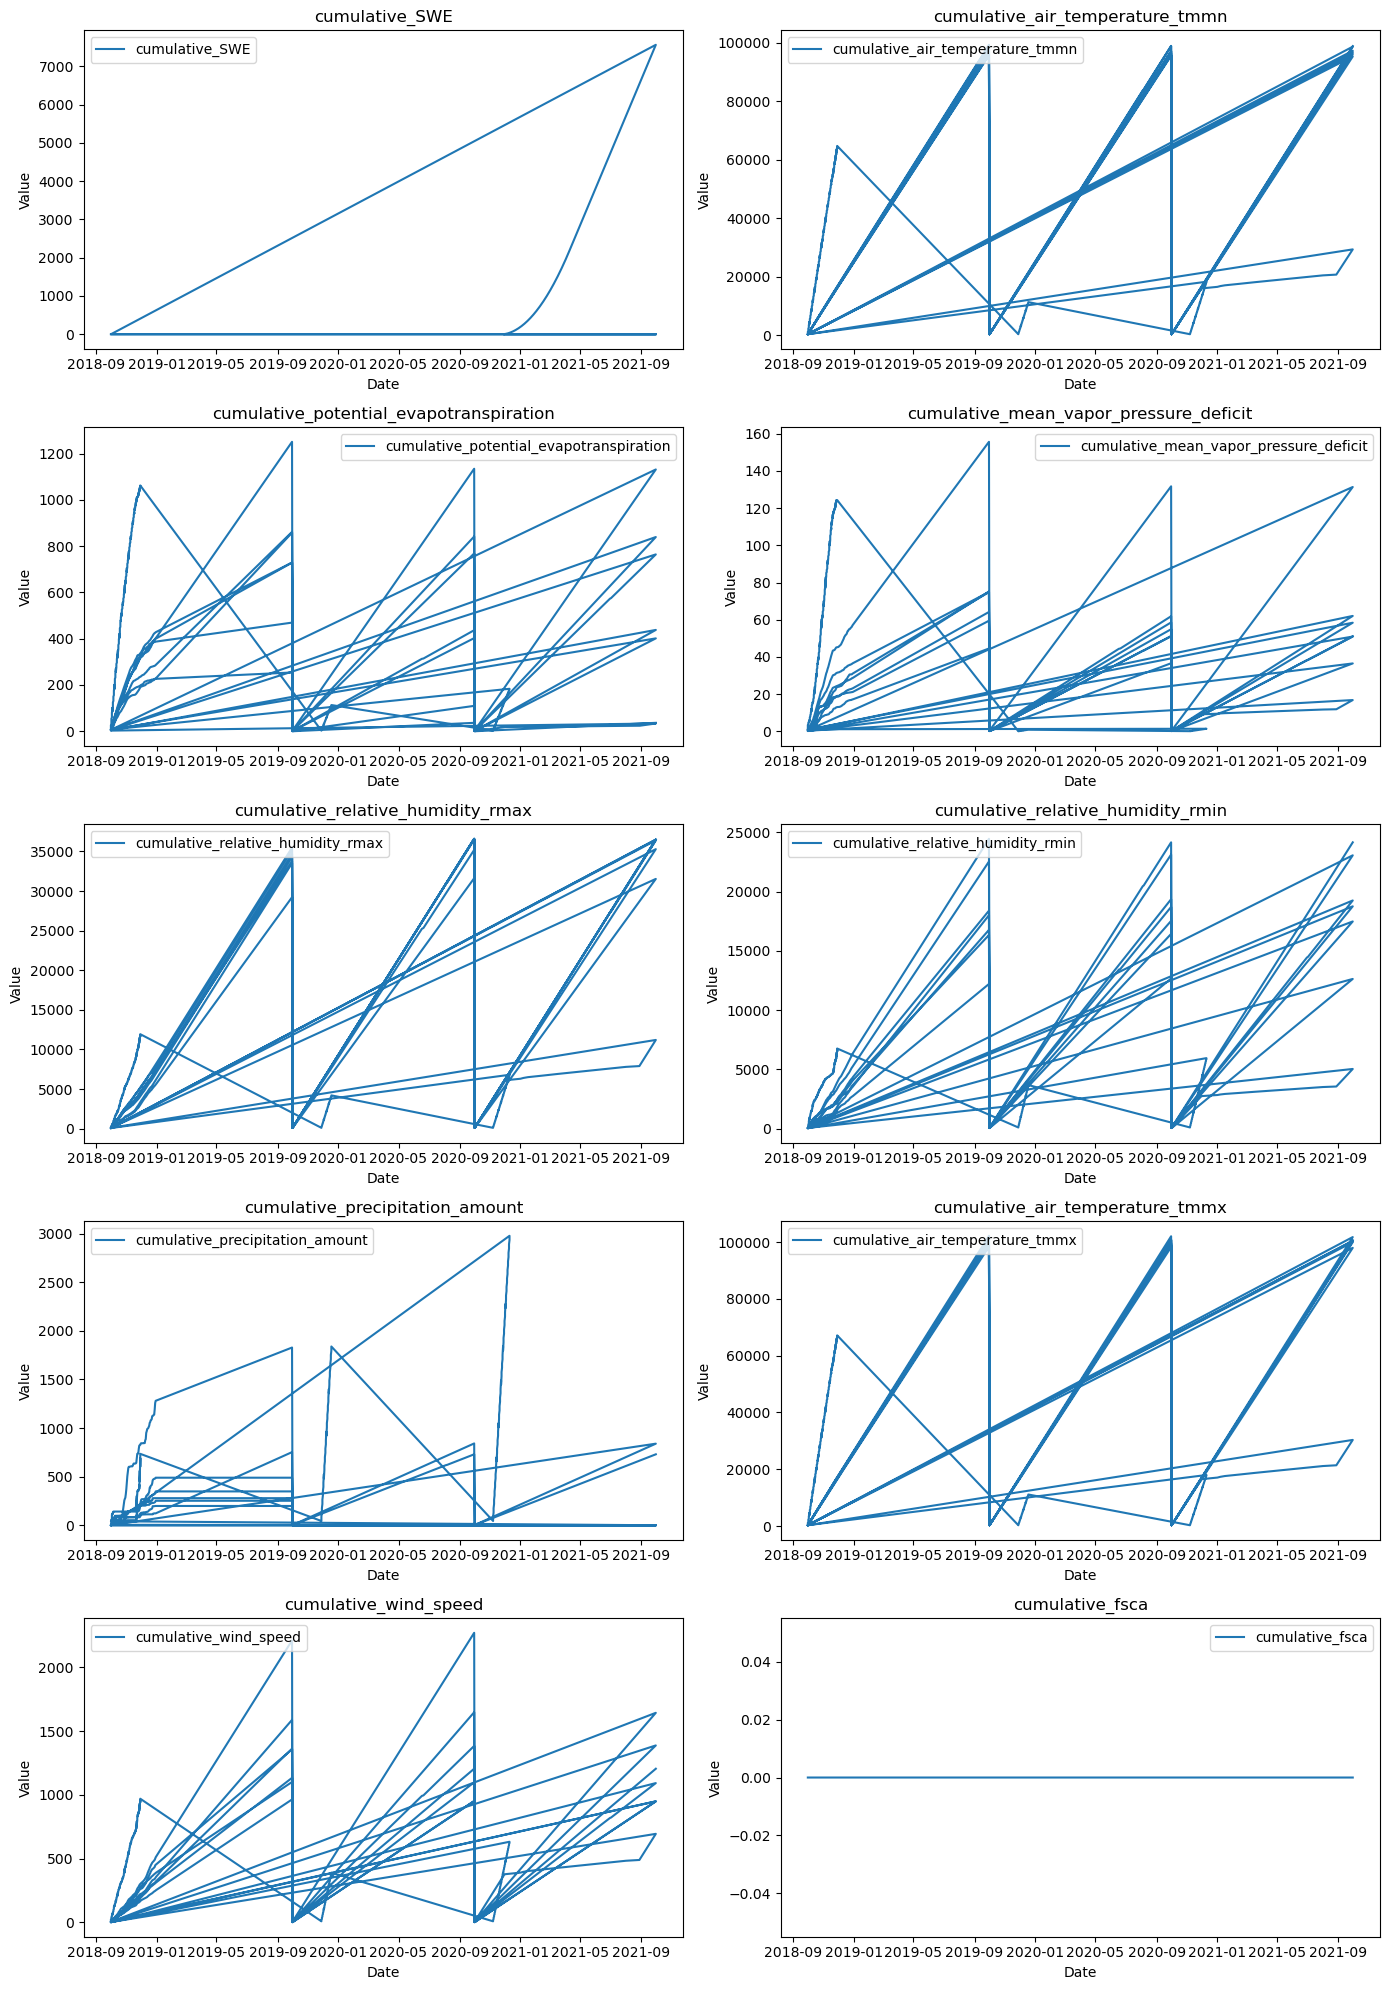

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def add_cumulative_columns(input_csv, output_csv, force=False):
    """
    Add cumulative columns to the time series dataset.

    This function reads the time series CSV file created by `convert_to_time_series`, calculates cumulative values for specific columns, and saves the data to a new CSV file.
    """
    
    columns_to_be_cumulated = [
      "SWE",
      'air_temperature_tmmn',
      'potential_evapotranspiration', 
      'mean_vapor_pressure_deficit',
      'relative_humidity_rmax', 
      'relative_humidity_rmin',
      'precipitation_amount', 
      'air_temperature_tmmx', 
      'wind_speed',
      'fsca'
    ]

    # Read the time series CSV (ensure it was created using `convert_to_time_series` function)
    # directly read from original file
    df = pd.read_csv(input_csv)

    print("the column statistics from time series before cumulative: ")
    # Calculate summary statistics
    summary_stats = df.describe().transpose()
    plt.figure(figsize=(50, 30), dpi=300)
    # Create a heatmap of the summary statistics
    sns.heatmap(summary_stats, annot=True, fmt="g", cmap="viridis")

    plt.title('Heatmap of Summary Statistics for DataFrame Columns')
    plt.xlabel('Statistical Measures')
    plt.ylabel('Columns')
    plt.show()

    
    
    df['date'] = pd.to_datetime(df['date'])
    
    unique_years = df['date'].dt.year.unique()
    print("This is our unique years", unique_years)
    #current_df['fSCA'] = current_df['fSCA'].fillna(0)
    
    # only start from the water year 10-01
    # Filter rows based on the date range (2019 to 2022)
    start_date = pd.to_datetime('2018-10-01')
    end_date = pd.to_datetime('2021-09-30')
    df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    print("how many rows are left in the three water years?", len(df.index))
    df.to_csv(f"{current_ready_csv_path}.test_check.csv")

    # Define a function to calculate the water year
    def calculate_water_year(date):
        year = date.year
        if date.month >= 10:  # Water year starts in October
            return year + 1
        else:
            return year
    
    # every water year starts at Oct 1, and ends at Sep 30. 
    df['water_year'] = df['date'].apply(calculate_water_year)
    
    # Group the DataFrame by 'lat' and 'lon'
    grouped = df.groupby(['lat', 'lon', 'water_year'], group_keys=False)
    print("how many groups? ", len(grouped))
    
    # grouped = df.groupby(['lat', 'lon', 'water_year'], group_keys=False)
    for column in columns_to_be_cumulated:
        df[f'cumulative_{column}'] = grouped.apply(lambda group: group.sort_values('date')[column].cumsum())

    print("This is the dataframe after cumulative columns are added")
    print(df.columns)
    
    df.to_csv(output_csv, index=False)
    
    print(f"All the cumulative variables are added successfully! {target_time_series_cumulative_csv_path}")
    print("double check the swe_value statistics:", df["swe_value"].describe())
    cumulative_columns = [f'cumulative_{col}' for col in columns_to_be_cumulated]
    # Number of rows and columns for subplots
    n_rows = len(cumulative_columns) // 2
    n_cols = 2
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))

    # Flatten axes array if more than one row
    if n_rows > 1:
        axes = axes.flatten()

    # Plot each cumulative column in a subplot
    for i, col in enumerate(cumulative_columns):
        axes[i].plot(df['date'], df[col], label=col)
        axes[i].set_title(col)
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Value')
        axes[i].legend()

    # Adjust layout for readability
    plt.tight_layout()
    plt.show()

add_cumulative_columns(target_time_series_csv_path, target_time_series_cumulative_csv_path, force=True)


The addition of cumulative columns to the dataset offers a dynamic perspective on environmental time series data. By aggregating measurements such as temperature, precipitation, and wind speed, the function reveals the incremental changes and long-term accumulation of these factors over specific periods – particularly water years. This comprehensive view is instrumental in understanding trends and patterns that are not immediately apparent in daily or monthly data.

Cumulative statistics are particularly useful for examining the progressive impact of climatic variables on ecological systems. For instance, the cumulative snow-water equivalent (SWE) can indicate potential water resource trends, while cumulative evapotranspiration might reflect on agricultural or hydrological cycles. By tracking these accumulations over time and across different geographic locations, the function enables researchers and analysts to discern gradual environmental changes, assess resource availability, and predict ecological responses to climatic variations.


### Conclusion

The script effectively prepares SWE and meteorological data for detailed time series analysis by systematically cleaning the data, handling missing values through interpolation, transforming the data into a time series format, and enriching the dataset with cumulative information. This preparation allows for a more accurate and insightful exploration of environmental and climatic dynamics.